In [236]:
import sys
sys.path.append('../')

In [237]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import warnings
from scipy.optimize import minimize
from torch.utils.data import DataLoader

from src.model import SindyModel
from src.main import get_args
from src.dataloader import ScrewdrivingDataset

In [238]:
%matplotlib inline
plt.ioff()

In [239]:
ARGS = get_args()

model_dir = os.path.join('..', 'out', 'sindy-model-out', 'checkpoints')
processed_model_dir = os.path.join('..', 'out', 'sindy-out-processed')
singal_data_dir = os.path.join('..', 'out', 'sindy-data')
out_dir = os.path.join('..', 'out', 'time-results')

os.makedirs(out_dir, exist_ok=True)

In [240]:
test_loader = DataLoader(ScrewdrivingDataset(mode='test', **{**vars(ARGS), 'data_dir': singal_data_dir}))
test_x = torch.cat([batch[0] for batch in test_loader], dim=0)

test_y = [batch[1].numpy() for batch in DataLoader(ScrewdrivingDataset(mode='test', **{**vars(ARGS), 'data_dir': singal_data_dir}))]
test_y = np.concatenate(test_y, axis=0)
test_y = test_y.reshape(test_y.shape[0], test_y.shape[-1])

In [241]:
def signal_error(params, reference_signals, target_signals):
    adjusted_signals = adjust_signal(target_signals, *params)
    return np.sum((reference_signals[0] - adjusted_signals[0]) ** 2) + np.sum((reference_signals[1] - adjusted_signals[1]) ** 2)

def adjust_signal(target_signals, mean_adjustment, time_shift):
    return [
        adjust_signal_single(target_signals[0], mean_adjustment, time_shift),
        adjust_signal_single(target_signals[1], mean_adjustment, time_shift),
    ]
    
def adjust_signal_single(target_signal, mean_adjustment, time_shift):
    shifted_target_signal = np.interp(np.arange(len(target_signal)), np.arange(len(target_signal)) - time_shift, target_signal)
    return shifted_target_signal + mean_adjustment

In [242]:
def gen_pos_from_vel(start_pos, vel_x, vel_y):
    positions = [start_pos]
    x, y = start_pos
    time_period = 1 / 30  # seconds
    
    for t in range(segment_length - 1):
        x += np.real(vel_x[t]) * time_period
        y += np.real(vel_y[t]) * time_period
        positions.append((x, y))

    positions = np.array(positions)
    
    return [positions[:, 0], positions[:, 1]]

In [243]:
def check_circle_entry(positions, cc, cr):
    for idx, pos in enumerate(positions):
        distance = np.linalg.norm(pos - cc)
        # print(f'idx: {idx}, distance: {distance}')
        if distance <= cr:
            return idx
    return None

def generate_random_start(center, distance):
    angle = np.random.uniform(0, 2 * np.pi)
    x = center[0] + distance * np.cos(angle)
    y = center[1] + distance * np.sin(angle)
    return np.array([x, y])

In [244]:
model_params_df = pd.read_csv(os.path.join(processed_model_dir, 'cumulative_results.csv'))
segment_params_df = pd.read_csv(os.path.join(processed_model_dir, 'segmented', 'best_segmented_results.csv'))

model_names = model_params_df['model_name']

min_err = float('inf')
min_err_model = 'yo mama'

model_name = 'model_2024-05-10 21:22:16.041663.pth'
model_row = model_params_df[model_params_df.model_name == model_name].iloc[0]
segment_row = segment_params_df[segment_params_df.model_name == model_name].iloc[0]

segment_params = (segment_row.mean_adjustment, segment_row.time_shift)
full_x_params = (model_row.mean_adjustment_vx, model_row.time_shift_vx)
full_y_params = (model_row.mean_adjustment_vy, model_row.time_shift_vy)
ref_segment_start = segment_row.start_ref
target_segment_start = segment_row.start_target
segment_length = segment_row.segment_length


with torch.no_grad():
    model = SindyModel(**vars(ARGS))
    model.load_state_dict(torch.load(os.path.join(model_dir, model_name)))
    model.eval()
    
    pred_y = model(test_x).numpy()
    pred_y = pred_y.reshape(pred_y.shape[0], pred_y.shape[-1]).astype(np.complex64)
    
    reference_signal_x = np.copy(test_y)[:, 0]
    target_signal_x = pred_y[:, 0]
    adjusted_vx = adjust_signal_single(target_signal_x, *full_x_params)
    
    reference_signal_y = np.copy(test_y)[:, 1]
    target_signal_y = pred_y[:, 1]
    adjusted_vy = adjust_signal_single(target_signal_y, *full_y_params)
    
    best_segmented_vx, best_segmented_vy = adjust_signal([adjusted_vx, adjusted_vy], *segment_params)

    time_results = dict()
    circle_center = np.array([0, 0])
    circle_radius = 5
    
    for start_distance in range(11):
        episode_results = []
        none_count = 0
        
        while len(episode_results) < 100:
            start_pos = generate_random_start(circle_center, start_distance + circle_radius)
            stacked_gen_pos = np.column_stack(gen_pos_from_vel(
                start_pos,
                best_segmented_vx[target_segment_start:target_segment_start + segment_length],
                best_segmented_vy[target_segment_start:target_segment_start + segment_length]
            ))
            
            for idx in range(4):
                start_pos = stacked_gen_pos[-1]
                stacked_gen_pos = np.row_stack((
                    stacked_gen_pos, 
                    np.column_stack(gen_pos_from_vel(
                        start_pos,
                        best_segmented_vx[target_segment_start:target_segment_start + segment_length],
                        best_segmented_vy[target_segment_start:target_segment_start + segment_length]
                        ))
                ))
            
            entry_time = check_circle_entry(stacked_gen_pos, circle_center, circle_radius)
            
            if entry_time is not None:
                episode_results.append(entry_time)
            else:
                none_count += 1
        
        print(f'start_distance: {start_distance}, none_count: {none_count}')
        
        if none_count > 500:
            time_results[start_distance] = [np.nan]
            break
        else:
            time_results[start_distance] = episode_results
    

start_distance: 0, none_count: 5
start_distance: 1, none_count: 253
start_distance: 2, none_count: 342
start_distance: 3, none_count: 416
start_distance: 4, none_count: 351
start_distance: 5, none_count: 505


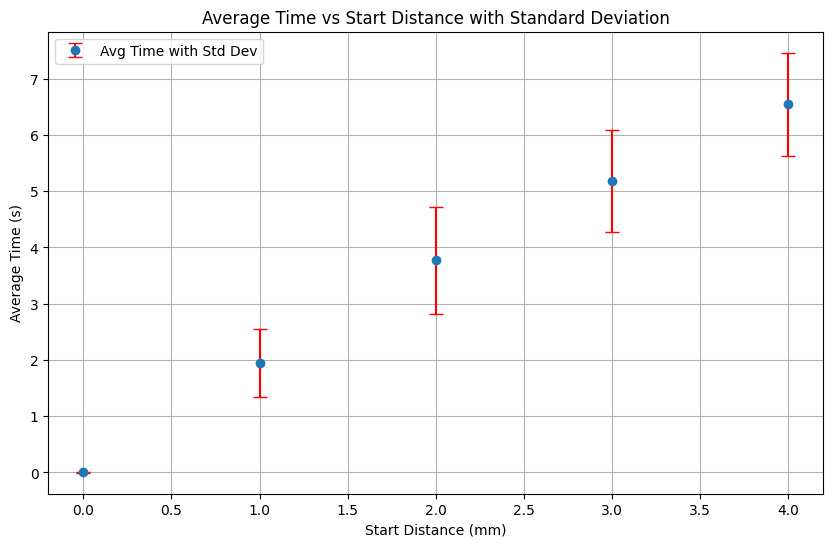

,Start Distance (mm),Average Time (s),Standard Deviation Time (s)
0,0,0.000666,0.004662
1,1,1.950803,0.603175
2,2,3.774726,0.949045
3,3,5.181715,0.901912
4,4,6.545745,0.916141
5,5,NaN,NaN


In [245]:
time_step_to_second_factor = 0.033301513000000005

start_distances = []
avg_times = []
std_dev_times = []

for key, val in time_results.items():
    start_distances.append(key)
    avg_times.append(np.average(val) * time_step_to_second_factor)
    std_dev_times.append(np.std(val) * time_step_to_second_factor)

plt.figure(figsize=(10, 6))

plt.errorbar(start_distances, avg_times, yerr=std_dev_times, fmt='o', ecolor='red', capsize=5, label='Avg Time with Std Dev')

plt.xlabel('Start Distance (mm)')
plt.ylabel('Average Time (s)')
plt.title('Average Time vs Start Distance with Standard Deviation')
plt.grid(True)
plt.legend()

plt.show()

pd.DataFrame({
    'Start Distance (mm)': start_distances,
    'Average Time (s)': avg_times,
    'Standard Deviation Time (s)': std_dev_times
})